In [13]:
import sys
import os 
%load_ext autoreload
%autoreload 2

os.chdir("/home/cooper-cooper/Desktop/vans/")

sys.path[0] = "/home/cooper-cooper/Desktop/vans/"


from utilities.variational import Autoencoder
import tensorflow_quantum as tfq
from utilities.qmodels import QNN,EnergyLoss
import matplotlib.colors as colors
import matplotlib

import tensorflow as tf

from utilities.evaluator import Evaluator
import numpy as np
from utilities.misc import give_kronecker_of_list

import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm
from utilities.variational import VQE
import cirq

from datetime import datetime

from utilities.variational import VQE
from utilities.evaluator import Evaluator
from utilities.idinserter import IdInserter
from utilities.simplifier import Simplifier
from utilities.unitary_killer_autoencoder import UnitaryMurder
from utilities.misc import scheduler_selector_temperature, scheduler_parameter_perturbation_wall #this outputs always 10 for now.




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

### load pure states

indexed_pure_states=[]
resolver_pure_states=[]
train_bonds=[]
energsin=[]
js=np.linspace(0.5,2.3,16)[0::3]
fcisfull=np.load("results/autoencoder/H2/fcisfull.npy")
isok=[]
teners=[]
compis=[]
for bond in tqdm(js):
    problem_config ={"problem" : "H2", "geometry": str([('H', (0., 0., 0.)), ('H', (0., 0., bond))]).replace("\'",""), "multiplicity":1, "charge":0, "basis":"sto-3g"}
    args={"n_qubits":4,"problem_config":problem_config, "load_displaying":False}
    evaluator_load = Evaluator(args,loading=True, path="../data-vans/")
    #energies.append(evaluator.raw_history[len(list(evaluator.raw_history.keys()))-1][-1])
    vqe_handler = VQE(n_qubits=4,noise_config={}, problem_config=problem_config,
                            return_lower_bound=True, lr=0.01, epochs=10000, patience=1000)
    siro, cuener, indexed_circuit, resolver, bestener,low = evaluator_load.evolution[evaluator_load.get_best_iteration()]#evaluator_load.get_best_iteration()]

    indexed_pure_states.append(indexed_circuit)
    resolver_pure_states.append(resolver)
    teners.append(cuener)
    train_bonds.append(bond)

100%|██████████| 6/6 [00:03<00:00,  1.76it/s]


In [3]:

auto_handler = Autoencoder(n_qubits=4,problem_config=problem_config, nb=2, lr = 0.01,
                        epochs=5000, verbose=0,
                        patience=200, optimizer="adam",
                        many_indexed_circuits=indexed_pure_states, many_symbols_to_values=resolver_pure_states)

au_evaluator = Evaluator(args={"n_qubits":4,
                            "problem_config":{"problem":"AutoencoderH2","n_qubits":len(auto_handler.qubits)},
                            "noise_config":{}},
                      info="", 
                      path="../data-vans/", acceptance_percentage=1e-7, reduce_acceptance_percentage=True,loading=True,nrun_load=7)


In [12]:
WW, en, indexed_circuit, resolver, a,b =au_evaluator.evolution[13]

inverse_indexed_circuit, inversolver, Wdagger = auto_handler.give_inverse(indexed_circuit,resolver)
Wdagger=cirq.unitary(Wdagger)


def compute_fidelity(input_state, encoding, channel, decoding):
    """
    we assume input_state is a ket.
    """
    st = np.dot(encoding, input_state)
    st = np.dot(channel, st)
    st = np.dot(decoding, st)
    return np.round(np.dot(np.conjugate(input_state),st), 16)

def compute_energy(input_state, encoding, channel, decoding, observable):
    """
    we assume input_state is a ket.
    """
    st = np.dot(encoding, input_state)
    st = np.dot(channel, st)
    st = np.dot(decoding, st)
    return np.dot(np.conjugate(st),np.dot(observable,st))


bond_train=np.linspace(0.5,2.3,16)[0::3]
bond_test=[]
test_energies = []
test_states=[]
train_energies=[]
fcis=[]
fcis_test=[]
eners=[]
fcis_train=[]
train_states=[]

batch_test = []
batch_train = []
for b in tqdm(np.linspace(0.5,2.3,16)):
    
    problem_config ={"problem" : "H2", "geometry": str([('H', (0., 0., 0.)), ('H', (0., 0., b))]).replace("\'",""), "multiplicity":1, "charge":0, "basis":"sto-3g"}
    args={"n_qubits":4,"problem_config":problem_config, "load_displaying":False}
    
    vqe_evaluator = Evaluator(args,loading=True, path="../data-vans/")

    vqe_handler = VQE(n_qubits=4,noise_config={}, problem_config=problem_config,
                            return_lower_bound=True, lr=0.01, epochs=4000,patience=400)
    
    siro, cuener, indexed_circuit, resolver, bestener,low = vqe_evaluator.evolution[vqe_evaluator.get_best_iteration()]#evaluator_load.get_best_iteration()]
    ene = cuener
    
    if not (b in bond_train):
        bond_test.append(b)
        test_energies.append(ene)
        fcis_test.append(vqe_handler.lower_bound_energy)
        test_states.append(cirq.unitary(siro)[:,0])
        
        batch_test.append(siro)
    else:
        train_states.append(cirq.unitary(siro)[:,0])
        train_energies.append(ene)
        fcis_train.append(vqe_handler.lower_bound_energy)
        batch_train.append(siro)


100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


In [14]:
projector = give_kronecker_of_list([auto_handler.zero_proj(vqe_handler.qubits[k]).matrix() for k in range(auto_handler.nb)])
channel = np.kron(projector, np.eye(2**(auto_handler.n_qubits - auto_handler.nb)))



ftest = [compute_fidelity(test_states[k], cirq.unitary(WW), channel, Wdagger) for k in range(len(test_states))]
ftrain = [compute_fidelity(test_states[k], cirq.unitary(WW), channel, Wdagger) for k in range(len(train_states))]

In [15]:
def give_q(a):
    return [np.mean(a), np.min(a), np.max(a)]

In [19]:
flotest = -np.log10(1-np.array(ftest))
flotrain = -np.log10(1-np.array(ftrain))
print(np.real(np.round(give_q(flotest),2)))
print(np.real(np.round(give_q(flotrain),2)))

[6.17 3.61 6.95]
[6.49 5.05 6.95]


/home/cooper-cooper/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


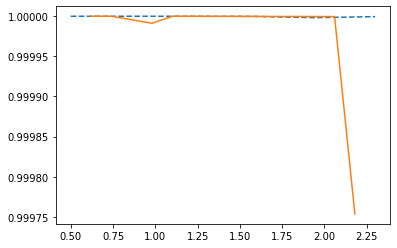

In [20]:
plt.plot(bond_train,np.real(list([compute_fidelity(train_states[k], cirq.unitary(WW), channel, Wdagger) for k in range(len(train_states))])),'--')
plt.plot(bond_test,[compute_fidelity(test_states[k], cirq.unitary(WW), channel, Wdagger) for k in range(len(test_states))])

In [21]:
things = au_evaluator.evolution[au_evaluator.get_best_iteration()]
model = QNN(symbols = list(things[3].keys()), observable=auto_handler.observable,batch_sizes=len(batch_train))
model.compile(loss=EnergyLoss(mode_var="autoencoder"))

import copy
pp = copy.deepcopy(batch_train)
for k in pp:
    k.append(things[0])
    
preds = model(tfq.convert_to_tensor(pp))
model.compiled_loss(preds,preds)

things = au_evaluator.evolution[au_evaluator.get_best_iteration()]

model = QNN(symbols = list(things[3].keys()), observable=auto_handler.observable,batch_sizes=len(batch_test))
            
model.compile(loss=EnergyLoss(mode_var="autoencoder"))

pp = copy.deepcopy(batch_test)
for k in pp:
    k.append(things[0])
    
preds = model(tfq.convert_to_tensor(pp))
model.compiled_loss(preds,preds)

<tf.Tensor: shape=(), dtype=float32, numpy=2.4974346e-05>

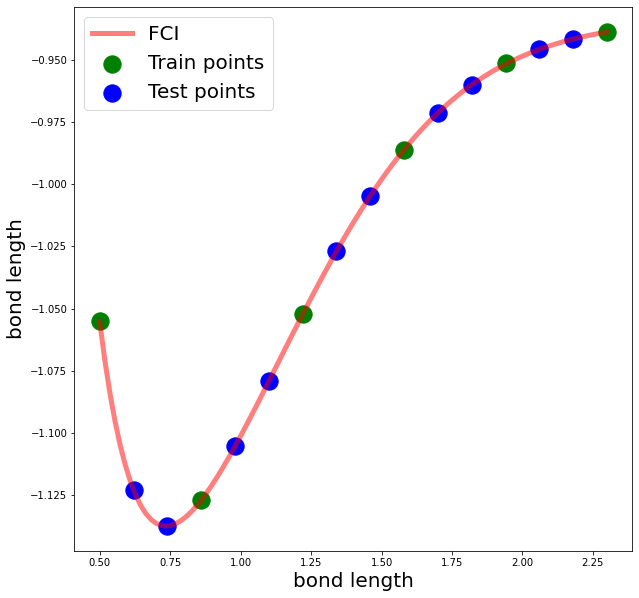

In [23]:
cost_value_test=[]
cost_value_train=[]

for ii in list(au_evaluator.evolution.values()):
    things = au_evaluator.evolution[au_evaluator.get_best_iteration()]
    model = QNN(symbols = list(things[3].keys()), observable=auto_handler.observable,batch_sizes=len(batch_test))
    model.compile(loss=EnergyLoss(mode_var="autoencoder"))

    pp = copy.deepcopy(batch_test)
    for k in pp:
        k.append(ii[0])

    preds = model(tfq.convert_to_tensor(pp))
    cost_value_test.append(model.compiled_loss(preds,preds))
    
    model1 = QNN(symbols = list(things[3].keys()), observable=auto_handler.observable,batch_sizes=len(batch_train))
    model1.compile(loss=EnergyLoss(mode_var="autoencoder"))
    
    ppo = copy.deepcopy(batch_train)
    for k in ppo:
        k.append(ii[0])

    preds = model1(tfq.convert_to_tensor(ppo))
    cost_value_train.append(model1.compiled_loss(preds,preds))
    
#fcisfull=[]
#for b in tqdm(np.linspace(0.5,2.3,100)):
#    problem_config ={"problem" : "H2", "geometry": [('H', (0., 0., 0.)), ('H', (0., 0., b))], "multiplicity":1, "charge":0, "basis":"sto-3g"}
#    args={"n_qubits":8,"problem_config":problem_config, "load_displaying":False,"specific_folder_name":"4_bd_{}".format(b)}
#    vqe_handler = VQE(n_qubits=4,noise_config={}, problem_config=problem_config,
#                            return_lower_bound=True)
#    fcisfull.append(vqe_handler.lower_bound_energy)
fcisfull=np.load("results/autoencoder/H2/fcisfull.npy")


plt.figure(figsize=(10,10))
plt.plot(np.linspace(0.5,2.3,100),fcisfull,color="red",linewidth=5,alpha=0.5,label="FCI")

plt.scatter(bond_train, np.squeeze(train_energies),s=300, color="green",label="Train points")
plt.scatter(bond_test, np.squeeze(test_energies), s=300,color="blue",label="Test points")

#plt.scatter(bond_train, fcis_train,s=300, color="green",label="Train points")
#plt.scatter(bond_test, fcis_test, s=300,color="blue",label="Test points")
plt.xlabel("bond length",size=20)
plt.ylabel("bond length",size=20)
plt.legend(prop={"size":20})
#plt.savefig(fol+"energies.png")

In [24]:
nconts = []
nparams = []
cost_value=[]
for k in list(au_evaluator.evolution.values()):
    cost_value.append(k[1])
    nconts.append(au_evaluator.count_cnots(k[2]))
    nparams.append(au_evaluator.count_params(k[2]))    

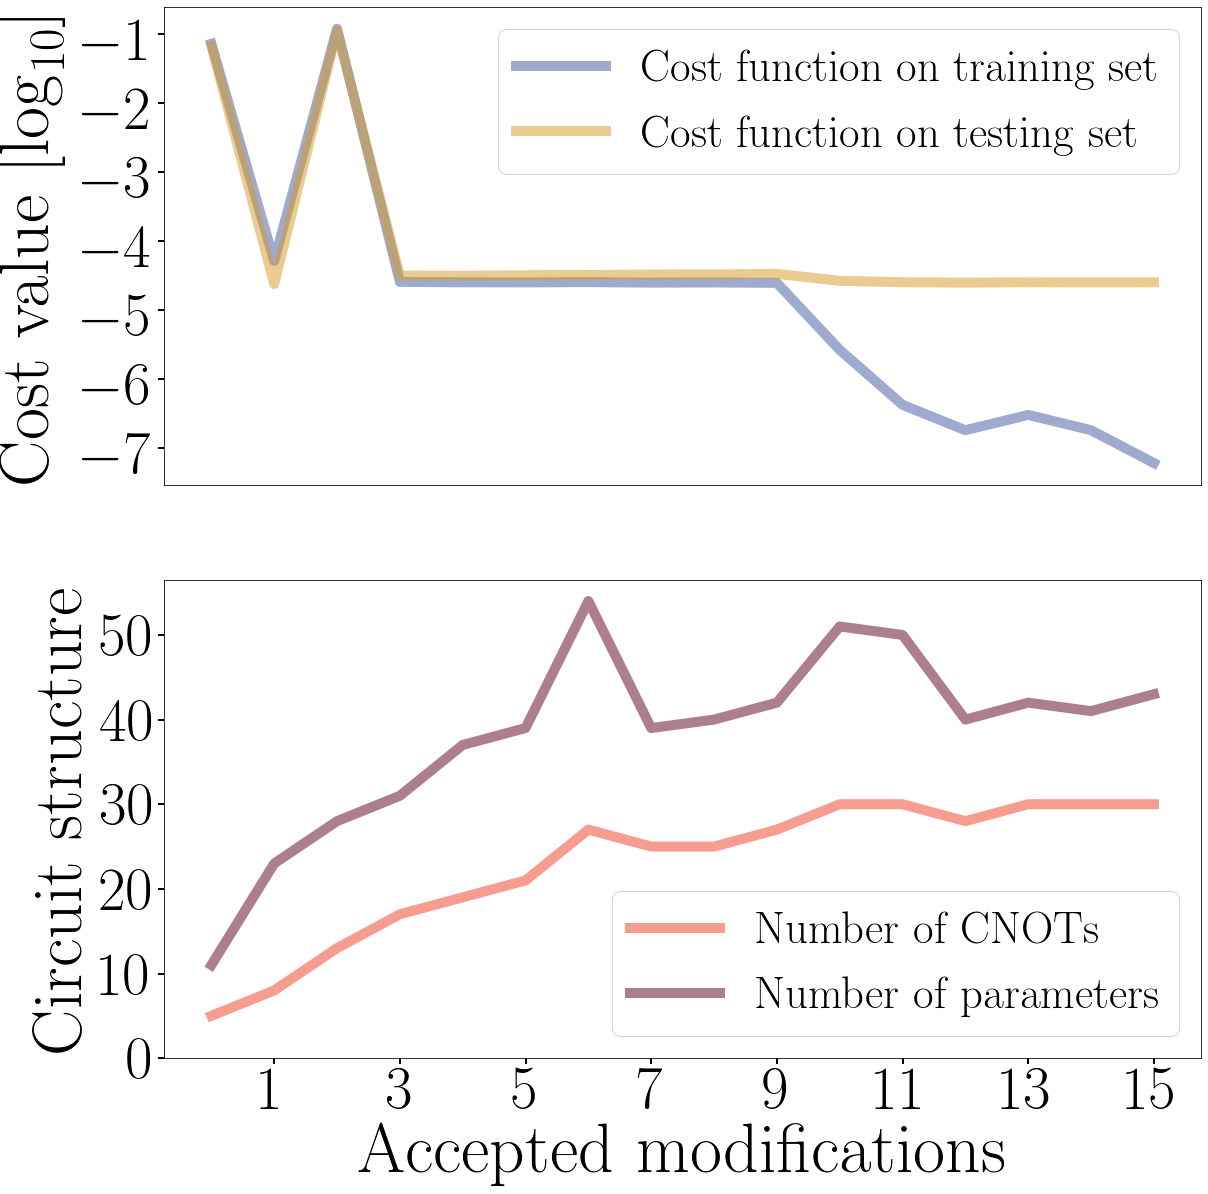

In [83]:

color1="#D79922"
color2="#4056A1"
color3="#F13C20"
color4="#5D001E"
color5="#8E8D8A"
import matplotlib

plt.style.use('results/plots/style.mplstyle')
matplotlib.rc("text",usetex=True)
plt.rcParams["font.family"] = "Times New Roman"

import matplotlib.colors as colors
converter = colors.ColorConverter()
plt.rcParams.update({'font.size': 45})


plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((2,1),(0,0))
ax2 = plt.subplot2grid((2,1),(1,0))
plt.subplots_adjust(bottom=0.15,left=0.18)
ax1.plot(np.log10(cost_value_train),color=converter.to_rgb(color2),linewidth=10,alpha=0.5,label="Cost function on training set")
ax1.plot(np.log10(cost_value_test),color=converter.to_rgb(color1),linewidth=10,alpha=0.5,label="Cost function on testing set")

ax1.tick_params(direction='out', length=6, width=2, colors='black', grid_alpha=0.5,labelsize=60)
ax1.xaxis.set_visible(False)
#ax1.xlabel("Accepted modification")
ax1.set_ylabel("Cost value "+r'$[\log _{10}]$',size=70)
ax1.legend(prop={"size":45})

ax2.plot(nconts,color=converter.to_rgb(color3),linewidth=10,alpha=0.5,label="Number of CNOTs")
ax2.plot(nparams,color=converter.to_rgb(color4),linewidth=10,alpha=0.5,label="Number of parameters")
ax2.tick_params(direction='out', length=6, width=2, colors='black', grid_alpha=0.5,labelsize=60)
ax2.set_xticks(range(1,len(cost_value_test), 2))
ax2.set_yticks(range(0,60,10))
ax1.set_yticks(np.arange(-7,0,1))

ax2.set_xlabel("Accepted modifications",size=70)
ax2.set_ylabel("Circuit structure",size=70)
ax2.legend(prop={"size":45})

plt.savefig("results/autoencoder/AE_numerics.pdf",format="pdf")

Let's do the HEA now

In [40]:
nparams[-1]

43

In [43]:
indexed_circuit = auto_handler.hea_ansatz_indexed_circuit(L=10, full=True)
print(auto_handler.count_cnots(indexed_circuit), auto_handler.count_params(indexed_circuit))

indexed_circuit = auto_handler.hea_ansatz_indexed_circuit(L=4, full=True)
print(auto_handler.count_cnots(indexed_circuit), auto_handler.count_params(indexed_circuit))

30 120
12 48


In [80]:
from utilities.variational import Autoencoder
heas = {}
auto_handler_hea = Autoencoder(n_qubits=4,problem_config=problem_config, nb=2, lr = 0.0001,
                        epochs=10000, verbose=0,
                        patience=1000, optimizer="adam",
                        many_indexed_circuits=indexed_pure_states, many_symbols_to_values=resolver_pure_states)

au_evaluator_hea = Evaluator(args={"n_qubits":4,
                            "problem_config":{"problem":"AutoencoderH2","n_qubits":len(auto_handler.qubits)},
                            "noise_config":{}},
                      info="", 
                      path="../data-vans/", acceptance_percentage=1e-7, reduce_acceptance_percentage=True)


indexed_circuit = auto_handler.hea_ansatz_indexed_circuit(L=10, full=True)#30 120

print("beggining to train!")
energy, symbol_to_value, training_evolution = auto_handler.autoencoder(indexed_circuit,parameter_perturbation_wall=0) #compute energy
#add initial info to au_evaluator
heas["10"]=[energy,symbol_to_value,training_evolution,indexed_circuit]


indexed_circuit = auto_handler.hea_ansatz_indexed_circuit(L=4, full=True)#12 48
print("beggining to train!")
energy, symbol_to_value, training_evolution = auto_handler.autoencoder(indexed_circuit,parameter_perturbation_wall=0) #compute energy
heas["4"] = [energy,symbol_to_value,training_evolution,indexed_circuit]

beggining to train!
beggining to train!


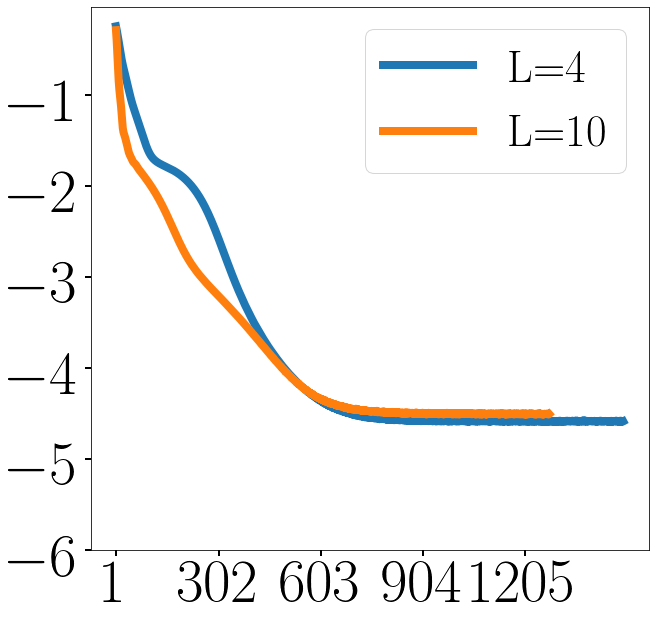

In [76]:
plt.figure(figsize=(10,10))
for k in ["4","10"]:
    plt.plot(np.log10(heas[k][2].history["energy"]),label="L={}".format(k))
plt.tick_params(direction='out', length=6, width=2, colors='black', grid_alpha=0.5,labelsize=60)
plt.xticks(range(1,len(training_evolution.history["energy"]))[::301])
plt.yticks(range(-1,-7,-1))
plt.legend()
plt.savefig("autohea-1.pdf",format="pdf")

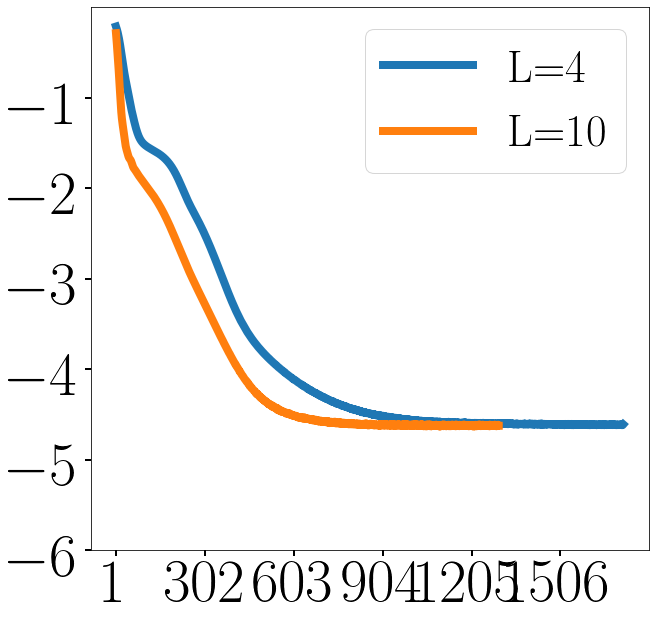

In [70]:
plt.figure(figsize=(10,10))
for k in ["4","10"]:
    plt.plot(np.log10(heas[k][2].history["energy"]),label="L={}".format(k))
plt.tick_params(direction='out', length=6, width=2, colors='black', grid_alpha=0.5,labelsize=60)
plt.xticks(range(1,len(training_evolution.history["energy"]))[::301])
plt.yticks(range(-1,-7,-1))
plt.legend()
plt.savefig("autohea.pdf",format="pdf")

Plot altoghether

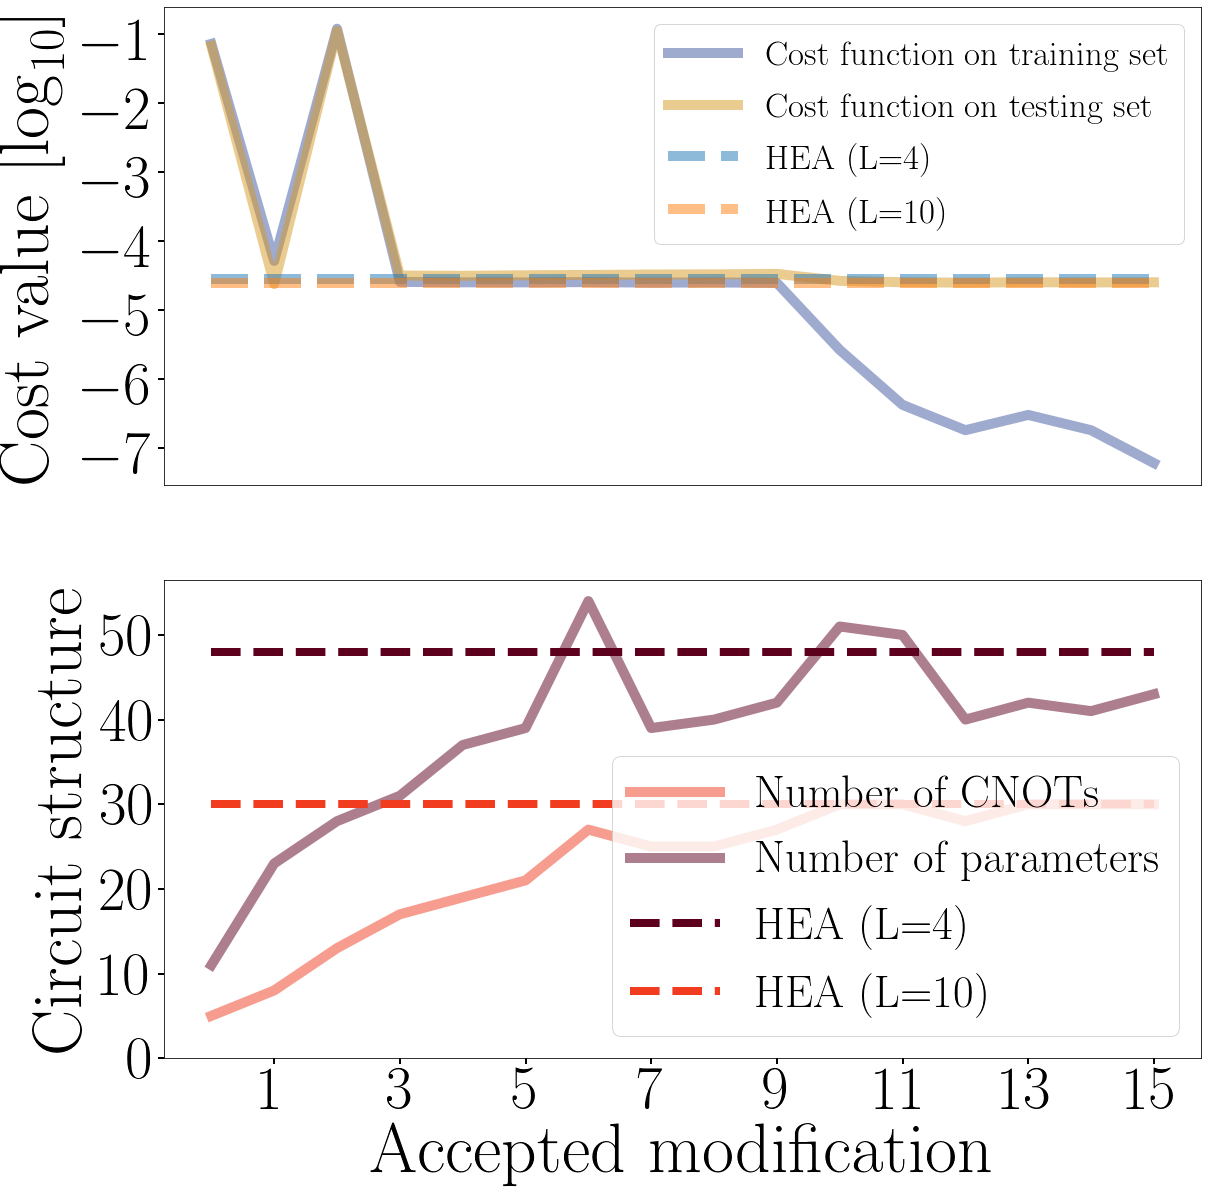

In [98]:

color1="#D79922"
color2="#4056A1"
color3="#F13C20"
color4="#5D001E"
color5="#8E8D8A"

plt.style.use('results/plots/style.mplstyle')
matplotlib.rc("text",usetex=True)
plt.rcParams["font.family"] = "Times New Roman"


converter = colors.ColorConverter()
plt.rcParams.update({'font.size': 45})


plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((2,1),(0,0))
ax2 = plt.subplot2grid((2,1),(1,0))
plt.subplots_adjust(bottom=0.15,left=0.18)
ax1.plot(np.log10(cost_value_train),color=converter.to_rgb(color2),linewidth=10,alpha=0.5,label="Cost function on training set")
ax1.plot(np.log10(cost_value_test),color=converter.to_rgb(color1),linewidth=10,alpha=0.5,label="Cost function on testing set")
for k in ["4","10"]:
    ax1.plot(np.ones(len(cost_value_train))*np.log10(heas[k][0]),'--',alpha=0.5,linewidth=10,label="HEA (L={})".format(k))

ax1.tick_params(direction='out', length=6, width=2, colors='black', grid_alpha=0.5,labelsize=60)
ax1.xaxis.set_visible(False)
#ax1.xlabel("Accepted modification")
ax1.set_ylabel("Cost value "+r'$[\log _{10}]$',size=70)

ax2.plot(nconts,color=converter.to_rgb(color3),linewidth=10,alpha=0.5,label="Number of CNOTs")
ax2.plot(nparams,color=converter.to_rgb(color4),linewidth=10,alpha=0.5,label="Number of parameters")

ax2.plot(np.ones(len(cost_value_train))*48,'--',color=converter.to_rgb(color4),label="HEA (L={})".format(4))
ax2.plot(np.ones(len(cost_value_train))*30,'--',color=converter.to_rgb(color3),label="HEA (L={})".format(10))
    
ax2.tick_params(direction='out', length=6, width=2, colors='black', grid_alpha=0.5,labelsize=60)
ax2.set_xticks(range(1,len(cost_value_test), 2))
ax2.set_yticks(range(0,60,10))
ax1.set_yticks(np.arange(-7,0,1))

ax2.set_xlabel("Accepted modification",size=70)
ax2.set_ylabel("Circuit structure",size=70)
ax2.legend(prop={"size":45})
ax1.legend(prop={"size":35})

plt.savefig("results/autoencoder/AE_numerics.pdf",format="pdf")